## GIS Data Science
#### Data Science for Climate in Nepal

**Objective**
- Objective of the study is to analyze and get insights from GIS data of Nepal

In [36]:
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [37]:
# import required Python libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import fiona
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
import seaborn as sns
from rasterio.plot import show


In [38]:
# Load a shapefile data
path = r"Datasets/Vector/Shape_Data/local_unit.shp"
# Reading a shapefile data
gdf = gpd.read_file(path)


# Data Preliminary Check for Descriptive Statistics

In [39]:
print('CRS: ')
print(gdf.crs)

# Display the first few rows
print("Head: ")
print(gdf.head())

print('Geometry: ')
print(gdf.geometry)

#check for missing values
print('check for missing values')
print(gdf.isnull().sum())

#describe the date properties
print('Describe the date properties')
print(gdf.describe())
# Count unique State Code
print('Count unique State Code')
print(gdf["STATE_CODE"].value_counts().sort_index())
# Count unique District Code
print('Count unique District Code')
print(gdf["DISTRICT"].value_counts().sort_index())

CRS: 
GEOGCS["NepalDD",DATUM["D_Everest_Bangladesh",SPHEROID["Everest 1830 (1937 Adjustment)",6377276.345,300.8017,AUTHORITY["EPSG","7015"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Head: 
   STATE_CODE   DISTRICT        GaPa_NaPa     Type_GN Province  \
0           1  TAPLEJUNG  Aathrai Tribeni  Gaunpalika        1   
1           1  TAPLEJUNG       Maiwakhola  Gaunpalika        1   
2           1  TAPLEJUNG        Meringden  Gaunpalika        1   
3           1  TAPLEJUNG       Mikwakhola  Gaunpalika        1   
4           1  TAPLEJUNG     Phaktanglung  Gaunpalika        1   

                                            geometry  
0  POLYGON ((87.60985 27.37043, 87.61107 27.36943...  
1  POLYGON ((87.50402 27.42901, 87.50672 27.42831...  
2  POLYGON ((87.51272 27.56894, 87.51255 27.56859...  
3  POLYGON ((87.6885 27.70975, 87.68891 27.70938,...  
4  POLYGON ((87.83673 27.95137, 87.83735 27.95119...  
Geometry: 
0      POL

# Visualization of Spatial Distribution


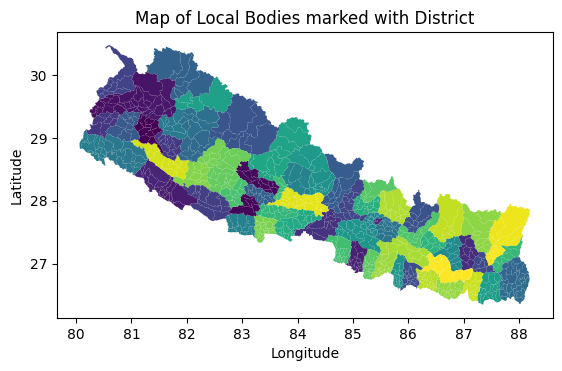

In [40]:
# Plot vector data
gdf.plot(column="DISTRICT", cmap="viridis")
plt.title("Map of Local Bodies marked with District")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

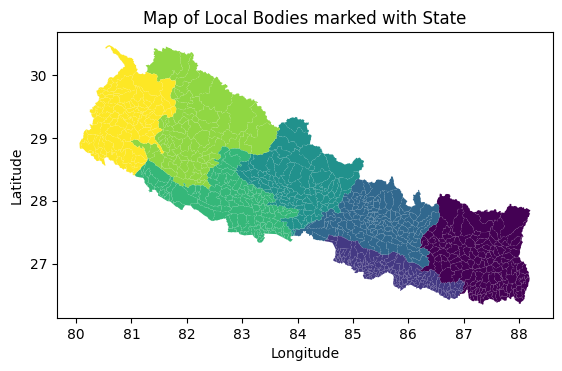

In [41]:
# Plot vector data
gdf.plot(column="STATE_CODE", cmap="viridis")
plt.title("Map of Local Bodies marked with State")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

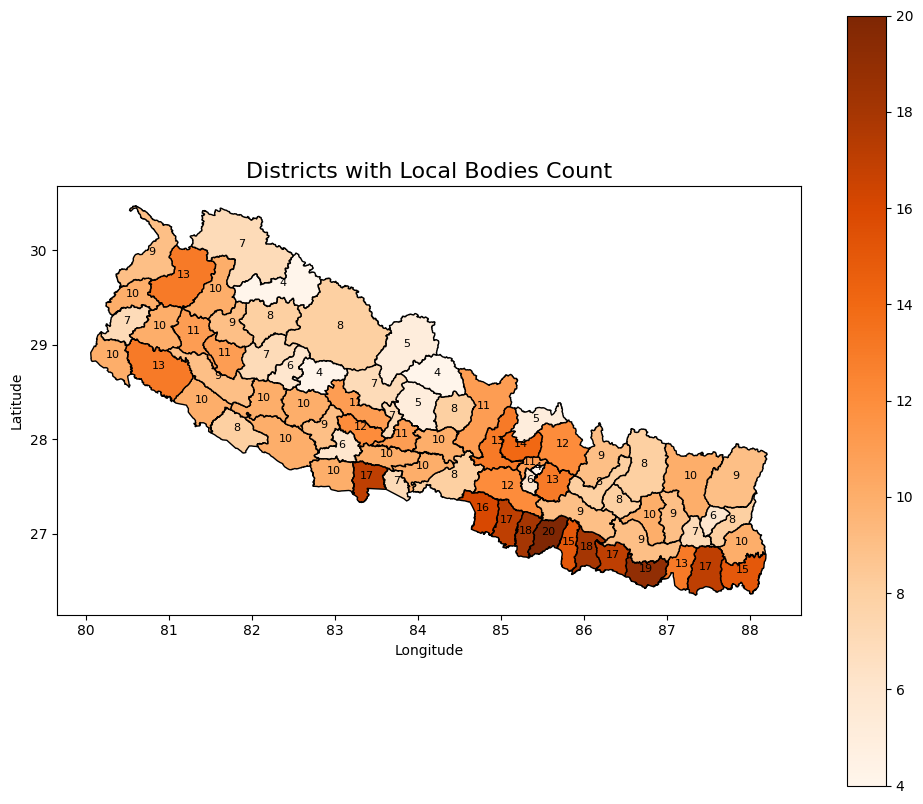

In [42]:
# Group by district and count local bodies
local_body_by_district = gdf.groupby("DISTRICT").size().reset_index(name="local_body_count")
# Merge count data back into the GeoDataFrame
local_bodies_with_counts = gdf.merge(local_body_by_district, on="DISTRICT", how="left")

# Dissolve local bodies into districts to create district-level geometries
districts = local_bodies_with_counts.dissolve(by="DISTRICT", as_index=False, aggfunc="first")

#print(districts)


# Add the local body count to the dissolved districts GeoDataFrame
districts["local_body_count"] = local_body_by_district["local_body_count"]

# Plot the districts and annotate counts
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot districts with a color gradient based on local body count
districts.plot(ax=ax, column="local_body_count", cmap="Oranges", legend=True, edgecolor="black")

# Add count labels on district centroids
for idx, row in districts.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, str(row["local_body_count"]), fontsize=8, ha="center", color="black")

# Customize plot
ax.set_title("Districts with Local Bodies Count", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show plot
plt.show()



In [43]:
path_nepal_admin_regions = r"Datasets/Raster/nepal_climate_data/nepal_admin_regions.gpkg"
path_nepal_glaciers = r"Datasets/Raster/nepal_climate_data/nepal_glaciers.gpkg"
path_nepal_rivers = r"Datasets/Raster/nepal_climate_data/nepal_rivers.gpkg"

# Working with Raster Data

In [44]:
#define path for rater datasets

path_nepal_precipitation_2020 = r"Datasets/Raster/nepal_climate_data/nepal_precipitation_2020.tif"
path_nepal_precipitation_2050 = r"Datasets/Raster/nepal_climate_data/nepal_precipitation_2050.tif"
path_nepal_temperature_2020 = r"Datasets/Raster/nepal_climate_data/nepal_temperature_2020.tif"
path_nepal_temperature_2050 = r"Datasets/Raster/nepal_climate_data/nepal_temperature_2050.tif"


def load_raster_data(file_path):
    # Load raster data
    with rasterio.open(file_path) as src:
        data = src.read(1)
    return data

precip_2020 = load_raster_data(path_nepal_precipitation_2020)
precip_2050 = load_raster_data(path_nepal_precipitation_2050)
temp_2020 = load_raster_data(path_nepal_temperature_2020)
temp_2050 = load_raster_data(path_nepal_temperature_2050)


# Basic Statistics of Precipitation Data

In [45]:
# Basic statistics
print('Statistics of precipitation 2020')
print("Mean:", np.mean(precip_2020))
print("Max:", np.max(precip_2020))
print("Min:", np.min(precip_2020))
print("Standard Deviation:", np.std(precip_2020))

# Basic statistics
print('\nStatistics of precipitation 2050')
print("Mean:", np.mean(precip_2050))
print("Max:", np.max(precip_2050))
print("Min:", np.min(precip_2050))
print("Standard Deviation:", np.std(precip_2050))


Statistics of precipitation 2020
Mean: 50.83796524449648
Max: 102.83267376645965
Min: 6.8563433623171495
Standard Deviation: 11.392472418361306

Statistics of precipitation 2050
Mean: 48.285593218473295
Max: 134.9692970311526
Min: -6.410086048906941
Standard Deviation: 16.390304034131695


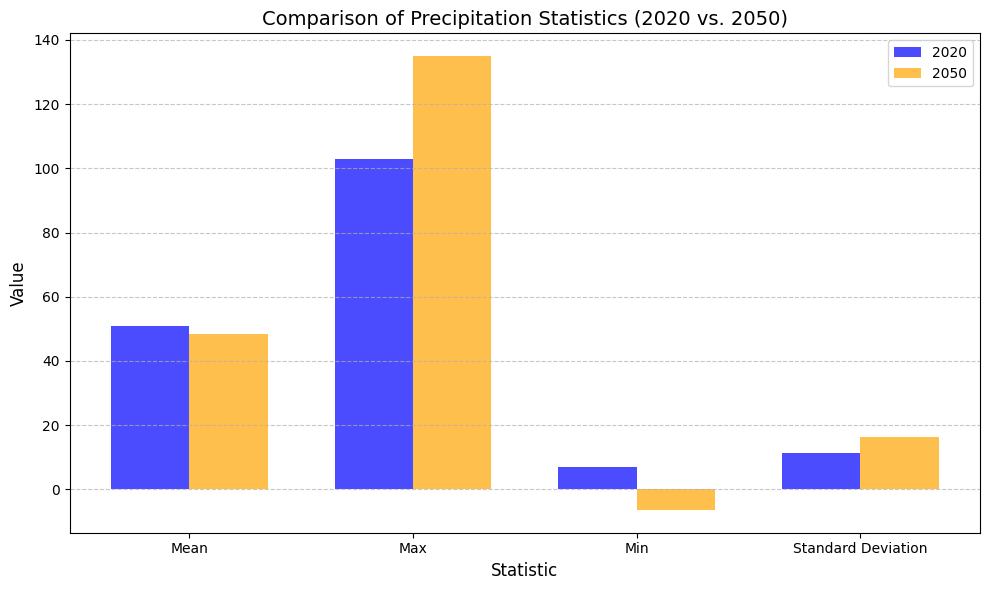

In [46]:
precip_2020_stats = {
    "Mean": np.mean(precip_2020),
    "Max": np.max(precip_2020),
    "Min": np.min(precip_2020),
    "Standard Deviation": np.std(precip_2020),
}

precip_2050_stats = {
    "Mean": np.mean(precip_2050),
    "Max": np.max(precip_2050),
    "Min": np.min(precip_2050),
    "Standard Deviation": np.std(precip_2050),
}


# Comparing statistics of the precipatition data in bar chart
categories = list(precip_2020_stats.keys())
values_2020 = list(precip_2020_stats.values())
values_2050 = list(precip_2050_stats.values())

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, values_2020, width, label='2020', color='blue', alpha=0.7)
plt.bar(x + width/2, values_2050, width, label='2050', color='orange', alpha=0.7)

plt.xlabel("Statistic", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Comparison of Precipitation Statistics (2020 vs. 2050)", fontsize=14)
plt.xticks(x, categories, fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Conclusion from Precipitation Bar chart
Looking at the precipitation comparison bar chart it can be concluded that the minimum and maximum value of precipitation on 2020 is totally coverd with in the precipitation value of 2050.

[59.81159875 42.728264   18.09058402 ... 40.69022095 58.43441065
 69.55728881]


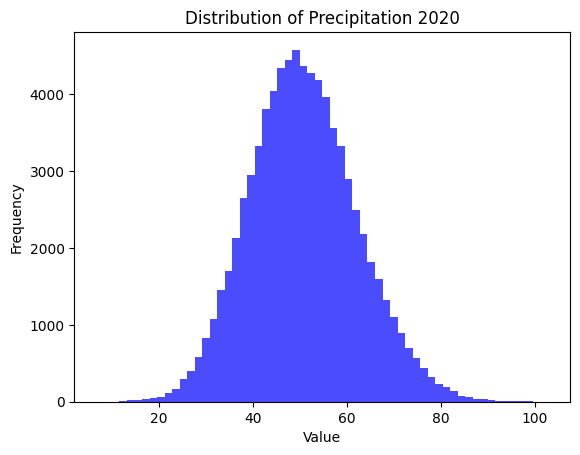

[39.40284744 41.08667713 15.84539498 ... 49.6176172  46.37932216
 76.05667601]


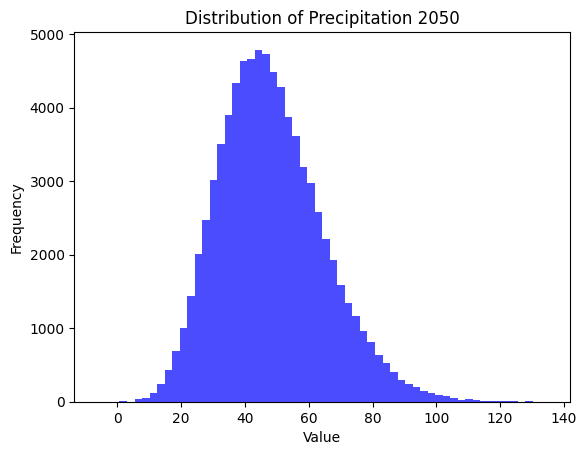

In [47]:
# Histogram
print(precip_2020.flatten())
plt.hist(precip_2020.flatten(), bins=60, color='blue', alpha=0.7)
plt.title("Distribution of Precipitation 2020")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Histogram
print(precip_2050.flatten())
plt.hist(precip_2050.flatten(), bins=60, color='blue', alpha=0.7)
plt.title("Distribution of Precipitation 2050")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

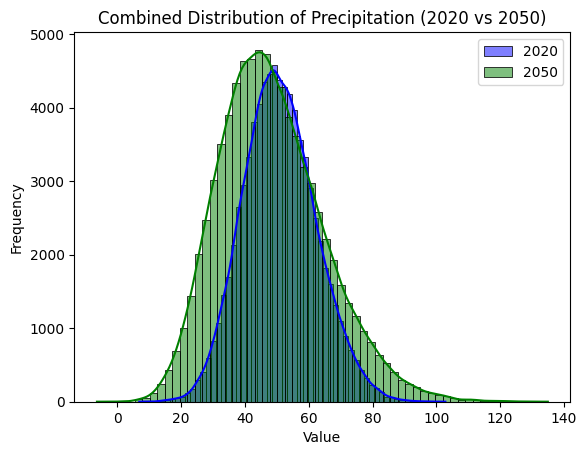

In [48]:
# Combined histogram for better comparison

sns.histplot(precip_2020.flatten(), bins=60, color='blue', alpha=0.5, label='2020', kde=True)
sns.histplot(precip_2050.flatten(), bins=60, color='green', alpha=0.5, label='2050', kde=True)


plt.title("Combined Distribution of Precipitation (2020 vs 2050)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.legend()

plt.show()

### Precipitation Histogram Conclusion
From the above histogram it can be concluded that the precipitation on 2020 is more concentrated to center line than precipitation on 2050. Both lower and higher side of precipitation value of 2020 is mostly covered with in the precipitation value of 2050.

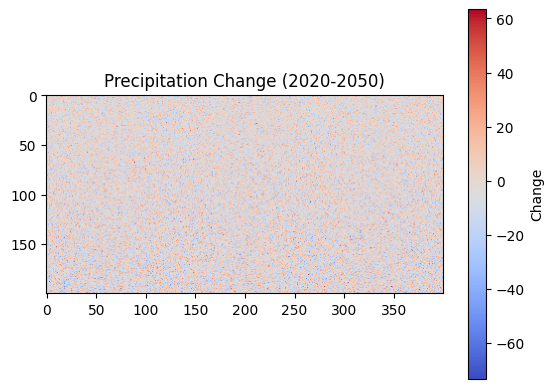

In [49]:
# Calculate change
change = precip_2050 - precip_2020
plt.imshow(change, cmap='coolwarm')
plt.title("Precipitation Change (2020-2050)")
plt.colorbar(label="Change")
plt.show()

In [50]:
def get_monthly_value(year_data):
    return [year_data[i] for i in range (1,13)]

def get_month_mean_value(year_data):
    return [np.mean(month) for month in get_monthly_value(year_data)]



## Comparing month wise trends for precipitation data for both 2020 and 2050

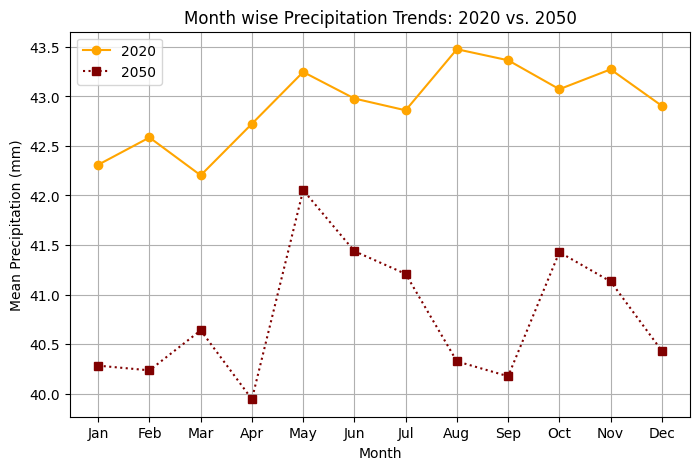

In [51]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, 13), get_month_mean_value(precip_2020), marker="o", linestyle="-", color="orange", label="2020")
plt.plot(range(1, 13), get_month_mean_value(precip_2050), marker="s", linestyle="dotted", color="maroon", label="2050")

plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Mean Precipitation (mm)")
plt.title("Month wise Precipitation Trends: 2020 vs. 2050")
plt.legend()
plt.grid()

plt.show()

# Basic Statistics of Temperature Data

In [52]:
# Basic statistics
print('Statistics of Temperature 2020')
print("Mean:", np.mean(temp_2020))
print("Max:", np.max(temp_2020))
print("Min:", np.min(temp_2020))
print("Standard Deviation:", np.std(temp_2020))

# Basic statistics
print('\nStatistics of Temperature 2050')
print("Mean:", np.mean(temp_2050))
print("Max:", np.max(temp_2050))
print("Min:", np.min(temp_2050))
print("Standard Deviation:", np.std(temp_2050))

Statistics of Temperature 2020
Mean: -7.577415755765925
Max: 8.138670708338557
Min: -23.198749681712457
Standard Deviation: 7.295507583300802

Statistics of Temperature 2050
Mean: -5.472906912267607
Max: 11.473132313566794
Min: -22.08736312988644
Standard Deviation: 7.159036215292309


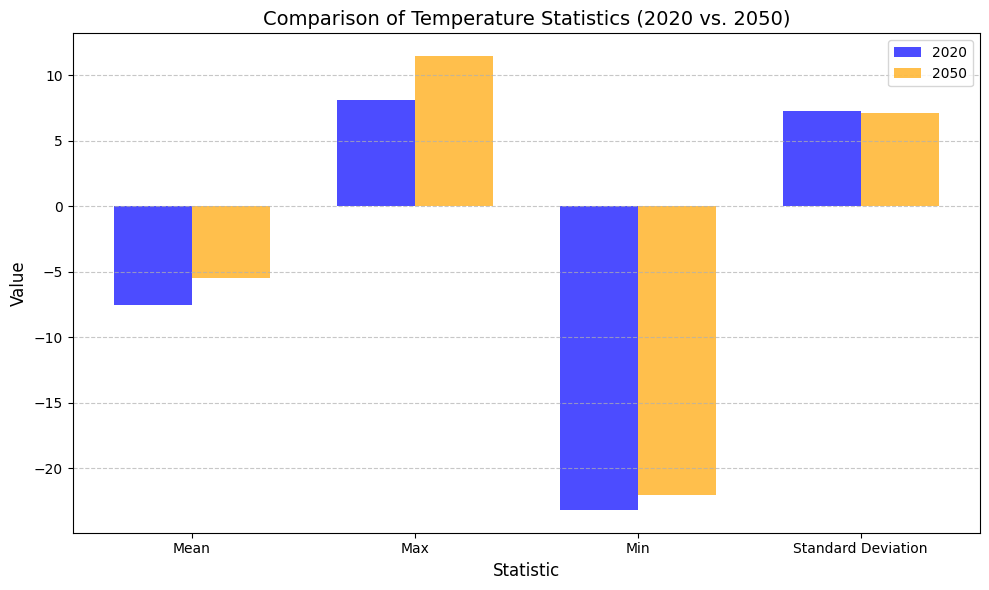

In [53]:
temp_2020_stats = {
    "Mean": np.mean(temp_2020),
    "Max": np.max(temp_2020),
    "Min": np.min(temp_2020),
    "Standard Deviation": np.std(temp_2020),
}

temp_2050_stats = {
    "Mean": np.mean(temp_2050),
    "Max": np.max(temp_2050),
    "Min": np.min(temp_2050),
    "Standard Deviation": np.std(temp_2050),
}


# Comparing statistics of the precipatition data in bar chart
categories = list(temp_2020_stats.keys())
values_2020 = list(temp_2020_stats.values())
values_2050 = list(temp_2050_stats.values())

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, values_2020, width, label='2020', color='blue', alpha=0.7)
plt.bar(x + width/2, values_2050, width, label='2050', color='orange', alpha=0.7)

plt.xlabel("Statistic", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Comparison of Temperature Statistics (2020 vs. 2050)", fontsize=14)
plt.xticks(x, categories, fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Conclusion from Temperature Bar chart
Looking at the temperature comparison bar chart it can be concluded that the minimum value of temperature on 2020 less than that of 2050 and Maximum value of temperature of 2050 is more than that of 2020.

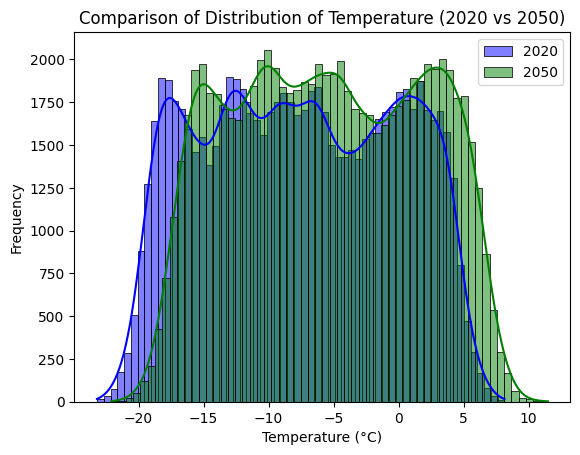

In [54]:
# Comparison of temperature for 2020 and 2050 through histogram plot

sns.histplot(temp_2020.flatten(), bins=60, color='blue', alpha=0.5, label='2020', kde=True)
sns.histplot(temp_2050.flatten(), bins=60, color='green', alpha=0.5, label='2050', kde=True)


plt.title("Comparison of Distribution of Temperature (2020 vs 2050)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")

plt.legend()

plt.show()

### Conclusion of comparison of distribution of temperature
From the comparison of distribution of temperature histogram chart, we can say that the trends for both 2020 and 2050 seems similar with a crossing around -13°C, with lowwer minimum temperature on 2020 and higher maximum temperature in 2050.

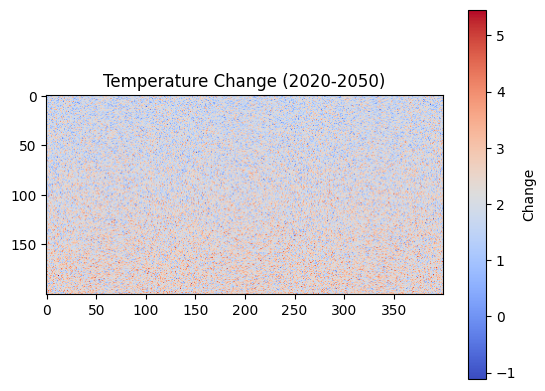

In [55]:
# Calculate change
change = temp_2050 - temp_2020
plt.imshow(change, cmap='coolwarm')
plt.title("Temperature Change (2020-2050)")
plt.colorbar(label="Change")
plt.show()

## Comparing month wise trends for temperature data for both 2020 and 2050

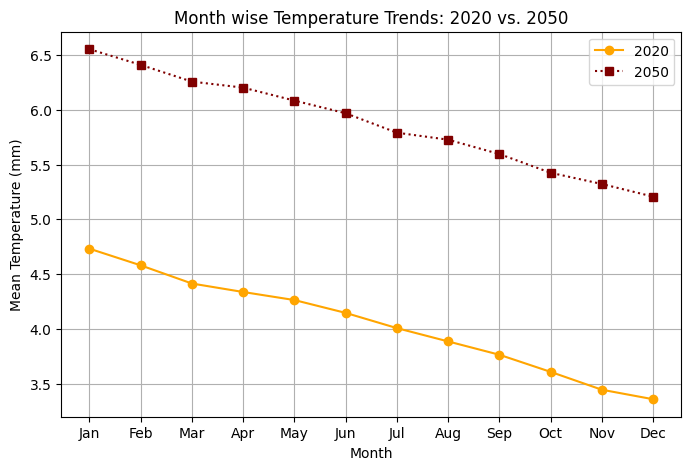

In [56]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, 13), get_month_mean_value(temp_2020), marker="o", linestyle="-", color="orange", label="2020")
plt.plot(range(1, 13), get_month_mean_value(temp_2050), marker="s", linestyle="dotted", color="maroon", label="2050")

plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Mean Temperature (mm)")
plt.title("Month wise Temperature Trends: 2020 vs. 2050")
plt.legend()
plt.grid()

plt.show()

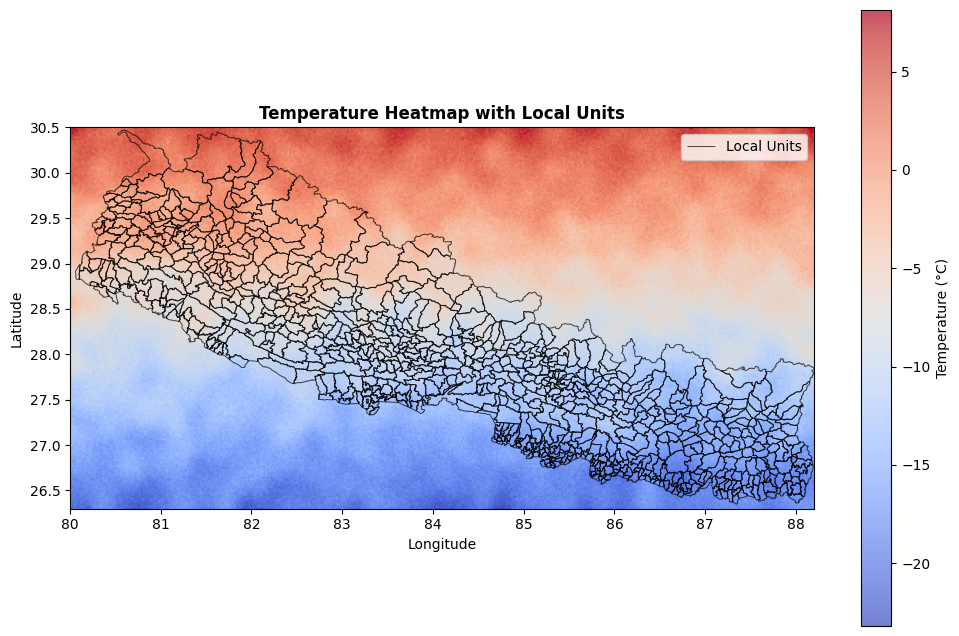

In [57]:

path_nepal_precipitation_2020 = r"Datasets/Raster/nepal_climate_data/nepal_precipitation_2020.tif"
path_nepal_precipitation_2050 = r"Datasets/Raster/nepal_climate_data/nepal_precipitation_2050.tif"
path_nepal_temperature_2020 = r"Datasets/Raster/nepal_climate_data/nepal_temperature_2020.tif"
path_nepal_temperature_2050 = r"Datasets/Raster/nepal_climate_data/nepal_temperature_2050.tif"

import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize


raster_path = path_nepal_temperature_2020
with rasterio.open(raster_path) as src:
    temperature_data = src.read(1)  # Read the first band
    temperature_meta = src.meta  # Metadata of the raster
    raster_transform = src.transform

local_units_path =  r"Datasets/Vector/Shape_Data/local_unit.shp"
local_units = gpd.read_file(local_units_path)

fig, ax = plt.subplots(figsize=(12, 8))

with rasterio.open(raster_path) as src:
    show(src, ax=ax, cmap='coolwarm', title='Temperature Heatmap with Local Units')

# Overlay the shapefile (local units)
local_units.boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, alpha=0.7, label='Local Units')

vmin, vmax = np.nanmin(temperature_data), np.nanmax(temperature_data)
norm = Normalize(vmin=vmin, vmax=vmax)

# Display raster
heatmap = ax.imshow(
    temperature_data,
    cmap="coolwarm",
    norm=norm,
    extent=(
        raster_transform[2],
        raster_transform[2] + raster_transform[0] * temperature_data.shape[1],
        raster_transform[5] + raster_transform[4] * temperature_data.shape[0],
        raster_transform[5],
    ),
    alpha=0.7,
)

cbar = plt.colorbar(heatmap, ax=ax, orientation="vertical")
cbar.set_label("Temperature (°C)")

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Conclusion from temperature heatmap with local units table
Northen regions (Top side of the map) shows higher temperature as indicated by red and orange shades where as the southern regions shows lower temperature represented by blue and light blue shades.

## Overall
Looking at the precipitation comparison bar chart it can be concluded that the minimum and maximum value of precipitation on 2020 is totally coverd with in the precipitation value of 2050.

From the above histogram it can be concluded that the precipitation on 2020 is more concentrated to center line than precipitation on 2050. Both lower and higher side of precipitation value of 2020 is mostly covered with in the precipitation value of 2050.

Looking at the temperature comparison bar chart it can be concluded that the minimum value of temperature on 2020 less than that of 2050 and Maximum value of temperature of 2050 is more than that of 2020.

From the comparison of distribution of temperature histogram chart, we can say that the trends for both 2020 and 2050 seems similar with a crossing around -13°C, with lowwer minimum temperature on 2020 and higher maximum temperature in 2050.

Northen regions (Top side of the map) shows higher temperature as indicated by red and orange shades where as the southern regions shows lower temperature represented by blue and light blue shades.